# Quantum Teleportation qBraid Challenge Solution

## Contents

### 1. Generate Teleportation Circuit with Amazon Braket and Measurement using Local Devices
### 2. Measuring Circuits using Rigetti
### 3. Transpiling Circuits into Qiskit's Language
### 4. Measurement with Qiskit's backend
### 5. Alice, Bob, and Corey (And Their Friends)

Import useful functions from Amazon Braket

In [3]:
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

import numpy as np
from matplotlib import pyplot as plt

### 1. Generate Teleportation Circuit with Amazon Braket

Here our `teleportation_circuit` function takes in `init_circuit` which initializes a state. The function then returns the teleportation circuit that helps transfer that initialized states.

In [4]:
#generate teleportation circuit with or without initial circuit that generates the initial state of qubit.
def teleportation_circuit(init_circuit = Circuit()):
    
    qc = init_circuit.copy()
    qc.h(1).cnot(1,2).cnot(0,1).h(0).cnot(1,2).cz(0,2)

    return qc

Since we can only measure all qubits rather than measuring one of them, we write `single_qubit_counts` that takes in `counts` of the measurement and `qubit` to return the measurement count if we just measure that qubit. 

In [5]:
#find the probability of measuring a specific qubit 
def single_qubit_counts(counts, qubit):
    single_qubit_counts = {'0':0, '1':0}
    for bit_string in counts:
        if bit_string[qubit] == '0':
            single_qubit_counts['0'] += counts[bit_string]
        elif bit_string[qubit]== '1':
            single_qubit_counts['1'] += counts[bit_string]
    return single_qubit_counts

#### a. Trivial state

First, assuming the initial state is the state |0>. The circuit that transfers the state |0> is:

In [6]:
#generate the teleporation circuit
circuit0 = teleportation_circuit()
print(circuit0)

T  : |0|1|2|3|4|
                
q0 : -----C-H-C-
          |   | 
q1 : -H-C-X-C-|-
        |   | | 
q2 : ---X---X-Z-

T  : |0|1|2|3|4|


Measurement the circuit with `LocalSimulator`

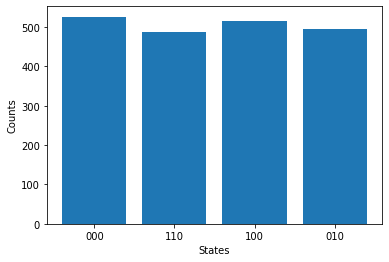

In [7]:
# set up device
device = LocalSimulator()
numshots = 2024

# run circuit
result0 = device.run(circuit0, shots=numshots).result()

# get measurement shots
counts0 = result0.measurement_counts

# visualize the result
plt.bar(counts0.keys(), counts0.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.show()

The count if we only measure the receiver's qubit

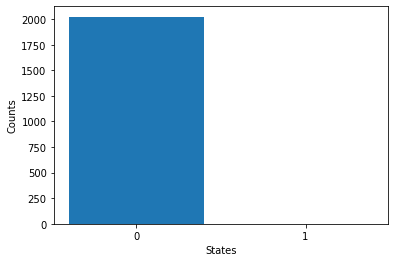

In [8]:
#counts of q2
counts0_q2 = single_qubit_counts(counts0, 2)

# visualize the results
plt.bar(counts0_q2.keys(), counts0_q2.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.show()

The result is trivial for the |0> state!

#### b. General State

Now, we try to initialize a general state with U3 gate. Our function `U3_instr` creates the `Instruction` to set U3 gate. 

In [9]:
def U3_instr(theta, phi, lam):
    U3_instr = []
    U3_instr.append(Instruction(Gate.Rz(phi), 0))
    U3_instr.append(Instruction(Gate.Rx(-np.pi /2),0))
    U3_instr.append(Instruction(Gate.Rz(theta),0))
    U3_instr.append(Instruction(Gate.Rx(+np.pi/2),0))
    U3_instr.append(Instruction(Gate.Rz(lam),0))
    return U3_instr

def inverseU3_instr(theta, phi, lam):
    return U3_instr(-theta, -lam, -phi)

The initial circuit that initializes the general state. Here we set `init_state_param` = [1,2,3]

In [10]:
#generate initial circuit
init_state_param  = [1,2,3]
theta, phi, lam = init_state_param
u3_instr = U3_instr(theta, phi, lam)
init_cir = Circuit(u3_instr)

Measurement of this state by `LocalSimulator`

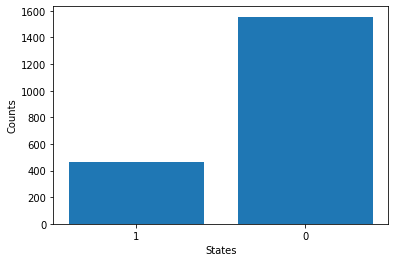

In [11]:
# set up device
device = LocalSimulator()
numshots = 2024

# run circuit
result1_init = device.run(init_cir, shots=numshots).result()

# get measurement shots
counts1_init = result1_init.measurement_counts

# visualize the result
plt.bar(counts1_init.keys(), counts1_init.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.show()

Generating the teleportation circuit to transfer the general state is not that hard!

In [12]:
#generate circuit
circuit1 = teleportation_circuit(init_cir)
print(circuit1)

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|
                                                 
q0 : -Rz(2)-Rx(-1.57)-Rz(1)-Rx(1.57)-Rz(3)-C-H-C-
                                           |   | 
q1 : -H-----C------------------------------X-C-|-
            |                                | | 
q2 : -------X--------------------------------X-Z-

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|


Measurement the general-state-teleportation circuit with `Local Simulator`

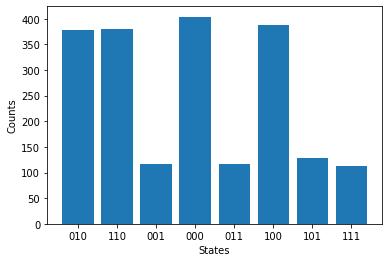

In [13]:
# set up device
device = LocalSimulator()
numshots = 2024


# run circuit
result1 = device.run(circuit1, shots=numshots).result()

# get measurement shots
counts1 = result1.measurement_counts

# visualize the result
plt.bar(counts1.keys(), counts1.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.show()

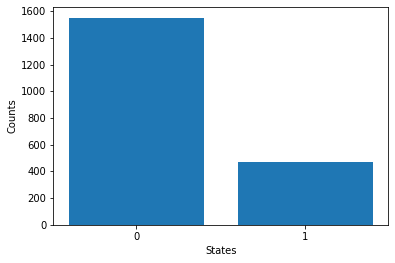

In [14]:
#counts of q2
counts1_q2 = single_qubit_counts(counts1, 2)

# visualize the results
plt.bar(counts1_q2.keys(), counts1_q2.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.show()

Pheww! The probabilities of the transferred general state is the same of the initial state. 

### 2. Measuring Circuits using Rigetti

#### a. Rigetti's Measurement of trivial state

In [19]:
#new circuit for psi = 0
circ0 = teleportation_circuit()
print(circ0)

T  : |0|1|2|3|4|
                
q0 : -----C-H-C-
          |   | 
q1 : -H-C-X-C-|-
        |   | | 
q2 : ---X---X-Z-

T  : |0|1|2|3|4|


In [106]:
# set up device
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")

# run circuit 
s3_folder = ("aaaa", "bbb")
rigetti_task0 = rigetti.run(circ0, s3_folder, shots=2024)

In [82]:
# get id and status of submitted task
rigetti_task0_id = rigetti_task0.id
rigetti_status0 = rigetti_task0.state()
print('ID of task:', rigetti_task0_id)
print('Status of task:', rigetti_status0)

ID of task: arn:aws:braket:us-west-1:592242689881:quantum-task/adb5b8b4-e68f-44c0-88f8-972fad3d1392
Status of task: QUEUED


In [104]:
# recover task
task_load0 = AwsQuantumTask(arn="arn:aws:braket:us-west-1:592242689881:quantum-task/adb5b8b4-e68f-44c0-88f8-972fad3d1392")

# print status
status = task_load0.state()
print('Status of (reconstructed) task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    rigetti_results = task_load.result()
    # print(rigetti_results)
    
    # get measurement counts
    rigetti_counts = rigetti_results.measurement_counts
    print('Measurement counts:', rigetti_counts)

    # plot results: see effects of noise
    plt.bar(rigetti_counts.keys(), rigetti_counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()

    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')


Status of (reconstructed) task: QUEUED


Sorry, your task is still being processed and has not been finalized yet.


#### b. Rigetti's Measurement of general state

In [20]:
#generate initial circuit
init_state_param  = [1,2,3]
theta, phi, lam = init_state_param
u3_instr = U3_instr(theta, phi, lam)
init_cir = Circuit(u3_instr)

#new circuit for general psi
circ1 = teleportation_circuit(init_cir)
print(circ1)

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|
                                                 
q0 : -Rz(2)-Rx(-1.57)-Rz(1)-Rx(1.57)-Rz(3)-C-H-C-
                                           |   | 
q1 : -H-----C------------------------------X-C-|-
            |                                | | 
q2 : -------X--------------------------------X-Z-

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|


In [105]:
# set up device
#rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")

# run circuit 
s3_folder = ("aaaa", "bbb")
rigetti_task1 = rigetti.run(circ1, s3_folder, shots=2024)

NameError: name 'rigetti' is not defined

In [ ]:
# get id and status of submitted task
rigetti_task1_id = rigetti_task1.id
rigetti_status1 = rigetti_task1.state()
print('ID of task:', rigetti_task1_id)
print('Status of task:', rigetti_status1)

### 3. Transpiling Circuits into Qiskit's Language

In this part, we transpile our circuits from Amazon `braket.Circuit` to `qiskit.QuantumCircuit`

In [16]:
from qbraid import circuit_wrapper, SUPPORTED_PROGRAM_TYPES

In [17]:
from qiskit import QuantumCircuit, ClassicalRegister, Aer, assemble, transpile, IBMQ

#### a. Trivial State

In [21]:
wrapped_circuit0 = circuit_wrapper(circ0)

In [22]:
print(circ0)

T  : |0|1|2|3|4|
                
q0 : -----C-H-C-
          |   | 
q1 : -H-C-X-C-|-
        |   | | 
q2 : ---X---X-Z-

T  : |0|1|2|3|4|


In [24]:
qiskit_circuit0 = wrapped_circuit0.transpile("qiskit")
print(qiskit_circuit0)

                    ┌───┐   
q_0: ────────────■──┤ H ├─■─
     ┌───┐     ┌─┴─┐└───┘ │ 
q_1: ┤ H ├──■──┤ X ├──■───┼─
     └───┘┌─┴─┐└───┘┌─┴─┐ │ 
q_2: ─────┤ X ├─────┤ X ├─■─
          └───┘     └───┘   


In [25]:
qiskit_qc0 = QuantumCircuit(3,1)
qiskit_qc0 += qiskit_circuit0
qiskit_qc0.measure(2,0)
print(qiskit_qc0)

                    ┌───┐      
q_0: ────────────■──┤ H ├─■────
     ┌───┐     ┌─┴─┐└───┘ │    
q_1: ┤ H ├──■──┤ X ├──■───┼────
     └───┘┌─┴─┐└───┘┌─┴─┐ │ ┌─┐
q_2: ─────┤ X ├─────┤ X ├─■─┤M├
          └───┘     └───┘   └╥┘
c: 1/════════════════════════╩═
                             0 


#### b. General State

In [26]:
wrapped_circuit1 = circuit_wrapper(circ1)

In [27]:
print(circ1)

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|
                                                 
q0 : -Rz(2)-Rx(-1.57)-Rz(1)-Rx(1.57)-Rz(3)-C-H-C-
                                           |   | 
q1 : -H-----C------------------------------X-C-|-
            |                                | | 
q2 : -------X--------------------------------X-Z-

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|


In [28]:
qiskit_circuit1 = wrapped_circuit1.transpile("qiskit")
print(qiskit_circuit1)

     ┌───────┐┌──────┐┌───────┐┌────┐┌───────┐     ┌───┐   
q_0: ┤ Rz(2) ├┤ √Xdg ├┤ Rz(1) ├┤ √X ├┤ Rz(3) ├──■──┤ H ├─■─
     └─┬───┬─┘└──────┘└───────┘└────┘└───────┘┌─┴─┐└───┘ │ 
q_1: ──┤ H ├─────■────────────────────────────┤ X ├──■───┼─
       └───┘   ┌─┴─┐                          └───┘┌─┴─┐ │ 
q_2: ──────────┤ X ├───────────────────────────────┤ X ├─■─
               └───┘                               └───┘   


In [29]:
qiskit_qc1 = QuantumCircuit(3,1)
qiskit_qc1 += qiskit_circuit1
qiskit_qc1.measure(2,0)
print(qiskit_qc1)

     ┌───────┐┌──────┐┌───────┐┌────┐┌───────┐     ┌───┐      
q_0: ┤ Rz(2) ├┤ √Xdg ├┤ Rz(1) ├┤ √X ├┤ Rz(3) ├──■──┤ H ├─■────
     └─┬───┬─┘└──────┘└───────┘└────┘└───────┘┌─┴─┐└───┘ │    
q_1: ──┤ H ├─────■────────────────────────────┤ X ├──■───┼────
       └───┘   ┌─┴─┐                          └───┘┌─┴─┐ │ ┌─┐
q_2: ──────────┤ X ├───────────────────────────────┤ X ├─■─┤M├
               └───┘                               └───┘   └╥┘
c: 1/═══════════════════════════════════════════════════════╩═
                                                            0 


### 4. Measurement with Qiskit's backend

In [42]:
from qiskit.tools.monitor import job_monitor, backend_overview
from qiskit.visualization import plot_histogram as plt_hist

In [44]:
IBMQ.save_account('f0d36272a1c90788a3255253bbc4aff73ba7b7b831de34f1efdb1e4751c707e606f466e1ac8d4117fcd33f31ddc957477692246bcac74ee007d495f8fe5ac06f')

configrc.store_credentials:WARNING:2022-04-10 11:47:04,835: Credentials already present. Set overwrite=True to overwrite.


In [45]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [46]:
provider= IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [47]:
backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 14             Pending Jobs: 2              Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      124.3          Avg. T1:      93.4           Avg. T1:      101.9
Avg. T2:      46.7           Avg. T2:      124.1          Avg. T2:      115.4



ibmq_lima                    ibmq_bogota                  ibmq_santiago
---------                    -----------                  -------------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 0              Pending Jobs: 55             Pending Jobs: 3
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Op

In [48]:
#Qiskit Devices, including simulator and real backends
simulator = Aer.get_backend('qasm_simulator')
lima =  provider.get_backend('ibmq_lima')
belem = provider.get_backend('ibmq_belem')
quito = provider.get_backend('ibmq_quito')

#### Trivial State Teleportation

In [98]:
#aer_qasm 
qc0_qasm = transpile(qiskit_qc0, simulator)
job0_qasm = simulator.run(assemble(qc0_qasm, simulator, shots = 8196))
result0_qasm = job0_qasm.result()
counts_qasm = result0_qasm.get_counts()

#lima
qc0_lima = transpile(qiskit_qc0, lima)
job0_lima = lima.run(assemble(qc0_lima, backend = lima, shots = 8196))
result0_lima = job0_lima.result()
counts0_lima = result0_lima.get_counts()

#belem
qc0_belem = transpile(qiskit_qc0, belem)
job0_belem = lima.run(assemble(qc0_belem, backend = belem, shots = 8196))
result0_belem = job0_belem.result()
counts0_belem = result0_belem.get_counts()

#quito
qc0_quito = transpile(qiskit_qc0, quito)
job0_quito = quito.run(assemble(qc0_quito, backend = quito, shots = 8196))
result0_quito = job0_quito.result()
counts0_quito = result0_quito.get_counts()

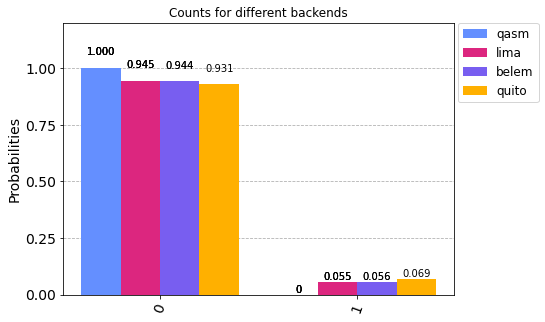

In [99]:
plt_hist([counts_qasm , counts0_lima, counts0_belem, counts0_quito], \
         title='Counts for different backends',\
         legend=['qasm','lima', 'belem', 'quito'])

#### General State Teleportation

In [101]:
#aer_qasm 
qc1_qasm = transpile(qiskit_qc1, simulator)
job1_qasm = simulator.run(assemble(qc1_qasm, simulator, shots = 8196))
result1_qasm = job1_qasm.result()
counts1_qasm = result1_qasm.get_counts()

#lima
qc1_lima = transpile(qiskit_qc1, lima)
job1_lima = lima.run(assemble(qc1_lima, backend = lima, shots = 8196))
result1_lima = job1_lima.result()
counts1_lima = result1_lima.get_counts()

#belem
qc1_belem = transpile(qiskit_qc1, belem)
job1_belem = lima.run(assemble(qc1_belem, backend = belem, shots = 8196))
result1_belem = job1_belem.result()
counts1_belem = result1_belem.get_counts()

#quito
qc1_quito = transpile(qiskit_qc1, quito)
job1_quito = quito.run(assemble(qc1_quito, backend = quito, shots = 8196))
result1_quito = job1_quito.result()
counts1_quito = result1_quito.get_counts()

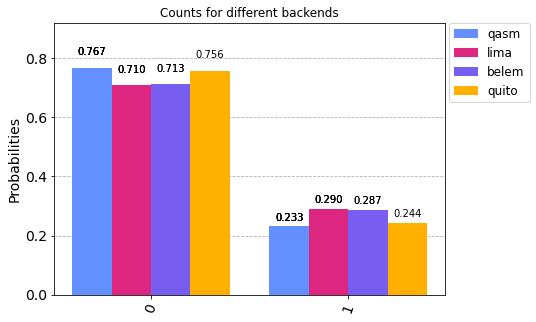

In [102]:
plt_hist([counts1_qasm , counts1_lima, counts1_belem, counts1_quito ], \
         title='Counts for different backends',\
         legend=['qasm','lima', 'belem', 'quito'])

### 5. Alice, Bob, and Corey (And Their Friends)

#### a. Multiple contributors

It would be interesting if we can transmit the information to multiple receivers. Unfortunately, the no-cloning theorem restricts us from doing that at the same time (Or you can actually teleport to London and New york at once). Thus, we come up with another situation that involves the third party.

Alice wants to apply a X gate on a quantum spin before transfering it to Bob. However, her X gates have been going through maintainance and are not able to be used yet. So, she calls Corey and he agrees to help her if she transfers the quantum state to him. After receiving the state, Corey will apply his X gate (which is perfect) to the Alice's quantum state and will then help her transfer the state to Bob. 

We will first generate the quantum circuit for this process.

In [30]:
qc = Circuit()
#Step1: Alice transfers her state to Corey
qc.h(1).cnot(1,2).cnot(0,1).h(0).cnot(1,2).cz(0,2)

#Step2: Corey applies her X-gate to Alice's state
qc.x(2)

#Step3: Corey transfers her state to Bob
qc.h(3).cnot(3,4).cnot(2,3).h(2).cnot(3,4).cz(2,4)

#print the circuit
print(qc)

T  : |0|1|2|3|4|5|6|7|8|
                        
q0 : -----C-H-C---------
          |   |         
q1 : -H-C-X-C-|---------
        |   | |         
q2 : ---X---X-Z-X-C-H-C-
                  |   | 
q3 : -H-C---------X-C-|-
        |           | | 
q4 : ---X-----------X-Z-

T  : |0|1|2|3|4|5|6|7|8|


The problem can be extended to more than 3 people and each can contribute by applying to the state some gates. We will write the function to generalize this.

In [31]:
def general_tele_circuit(num_people, contributing_instr_list):   
    """
    Parameters
    ----------
    num_people: int
        number of people "contributing" to the quantum state
    contributing_instr_list: list
        list of Instructions
    """
    qc = Circuit()
    for i in range(0, num_people-1):
        qc.add(contributing_instr_list[i], [2*i])
        qc.h(2*i+1).cnot(2*i+1,2*i+2).cnot(2*i,2*i+ 1).h(i).cnot(2*i+1,2*i+2).cz(2*i,2*i+2)
    qc.add(contributing_instr_list[-1], [2*(num_people-1)])
    return qc

This is the example of 3-people-contributing circuit

In [32]:
instr_list = [ Instruction(Gate.Rx(0.1), 0),Instruction(Gate.Ry(0.3), 0), \
              Instruction(Gate.Rx(0.4), 0)  ]
quc = general_tele_circuit(3, instr_list)

In [33]:
print(quc)

T  : |   0    |1|2|3| 4 |   5    |6|7|8|   9    |
                                                 
q0 : -Rx(0.10)---C-H-C---------------------------
                 |   |                           
q1 : -H--------C-X-C-|-H-------------------------
               |   | |                           
q2 : ----------X---X-Z---Ry(0.30)-C---C----------
                                  |   |          
q3 : -H--------C------------------X-C-|----------
               |                    | |          
q4 : ----------X--------------------X-Z-Rx(0.40)-

T  : |   0    |1|2|3| 4 |   5    |6|7|8|   9    |


In fact, the people contributing we mentioned previously do not have to be different people. In other words, a person can contribute multiple times. 

So assuming Alice transfers a state to Bo, then Bob changes it and returns the new state to Alice, the circuit would be similar to that of the 3-people-contributing circuit. 

#### Estimate the Error of Quantum Teleportation 

Now assuming Alice sends the states to Bob and after receiving the states he sends it back to her without changing anything. We will estimate the error by calculating the difference between the theoretical and the measured probability vector. The quantum circuit or this situation would be as follow

In [39]:
ab_qc = Circuit()
#Step1: Alice initializes the state with U3
ab_qc.add(U3_instr(1, 2, 3))

#Step1: Alice transfers her state to Corey
ab_qc.h(1).cnot(1,2).cnot(0,1).h(0).cnot(1,2).cz(0,2)

#Step2: Bob sends the state back to Bob
ab_qc.h(3).cnot(3,4).cnot(2,3).h(2).cnot(3,4).cz(2,4)

#print the circuit
print(ab_qc)

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|8|9|10|
                                                        
q0 : -Rz(2)-Rx(-1.57)-Rz(1)-Rx(1.57)-Rz(3)-C-H-C--------
                                           |   |        
q1 : -H-----C------------------------------X-C-|--------
            |                                | |        
q2 : -------X--------------------------------X-Z-C-H-C--
                                                 |   |  
q3 : -H-----C------------------------------------X-C-|--
            |                                      | |  
q4 : -------X--------------------------------------X-Z--

T  : |  0  |    1    |  2  |   3    |  4  |5|6|7|8|9|10|


In [75]:
#transpile into qiskit
qiskit_ab_qc=QuantumCircuit(5,1)+circuit_wrapper(ab_qc).transpile("qiskit")
qiskit_ab_qc.measure(4,0)
print(qiskit_ab_qc)

     ┌───────┐┌──────┐┌───────┐┌────┐┌───────┐     ┌───┐                   
q_0: ┤ Rz(2) ├┤ √Xdg ├┤ Rz(1) ├┤ √X ├┤ Rz(3) ├──■──┤ H ├─■─────────────────
     └─┬───┬─┘└──────┘└───────┘└────┘└───────┘┌─┴─┐└───┘ │                 
q_1: ──┤ H ├─────■────────────────────────────┤ X ├──■───┼─────────────────
       └───┘   ┌─┴─┐                          └───┘┌─┴─┐ │      ┌───┐      
q_2: ──────────┤ X ├───────────────────────────────┤ X ├─■───■──┤ H ├─■────
       ┌───┐   └───┘                               └───┘   ┌─┴─┐└───┘ │    
q_3: ──┤ H ├─────■─────────────────────────────────────────┤ X ├──■───┼────
       └───┘   ┌─┴─┐                                       └───┘┌─┴─┐ │ ┌─┐
q_4: ──────────┤ X ├────────────────────────────────────────────┤ X ├─■─┤M├
               └───┘                                            └───┘   └╥┘
c: 1/════════════════════════════════════════════════════════════════════╩═
                                                                         0 


Theoretical Measurement

In [59]:
theor_ab_qc=circuit_wrapper(Circuit(U3_instr(1, 2, 3))).transpile("qiskit")
print(theor_ab_qc)

   ┌───────┐┌──────┐┌───────┐┌────┐┌───────┐
q: ┤ Rz(2) ├┤ √Xdg ├┤ Rz(1) ├┤ √X ├┤ Rz(3) ├
   └───────┘└──────┘└───────┘└────┘└───────┘


In [56]:
from qiskit.quantum_info import Statevector

In [ ]:
theor_count = Statevector(theor_ab_qc).probabilities_dict()
print(theor_count)

In [91]:
def twoD_probvector(count, numshots=1):
    probvector = []
    probvector.append(count['0']/numshots) 
    probvector.append(count['1']/numshots)
    return probvector

In [90]:
theor_probvector = twoD_probvector(theor_count)

Measurement on IBMQ's real backends

In [76]:
#lima
t_ab_qc_lima = transpile(qiskit_ab_qc, lima)
job_lima = lima.run(assemble(t_ab_qc_lima, backend = lima, shots = 8196))
result_lima = job_lima.result()
counts_lima = result_lima.get_counts()

#belem
t_ab_qc_belem = transpile(qiskit_ab_qc, belem)
job_belem = lima.run(assemble(t_ab_qc_belem, backend = belem, shots = 8196))
result_belem = job_belem.result()
counts_belem = result_belem.get_counts()

#quito
t_ab_qc_quito = transpile(qiskit_ab_qc, quito)
job_quito = quito.run(assemble(t_ab_qc_quito, backend = quito, shots = 8196))
result_quito = job_quito.result()
counts_quito = result_quito.get_counts()

In [92]:
probvector_lima = twoD_probvector(counts_lima, 8196)
probvector_belem = twoD_probvector(counts_belem, 8196)
probvector_quito = twoD_probvector(counts_quito, 8196)

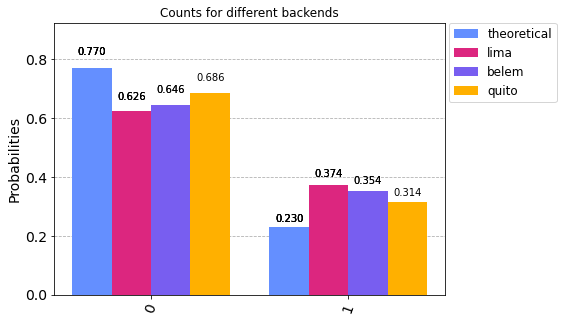

In [78]:
plt_hist([theor_count , counts_lima, counts_belem, counts_quito ], \
         title='Counts for different backends',\
         legend=['theoretical','lima', 'belem', 'quito'])

We will estimate the differences between the measured and the theoretical by computing the manhantan distance.

In [93]:
def manhatan_dist(a,b):
    sum = 0
    for i in range(len(a)):
        sum+=  np.abs(a[i]-b[i])
    return sum

In [94]:
diff_lima = manhatan_dist(probvector_lima, theor_probvector)
diff_belem = manhatan_dist(probvector_belem, theor_probvector)
diff_quito = manhatan_dist(probvector_quito, theor_probvector)

In [96]:
print('Differences between measurement on ibmq_lima and the theoretical results is', diff_lima)
print('Differences between measurement on ibmq_belem and the theoretical results is', diff_belem)
print('Differences between measurement on ibmq_quito and the theoretical results is', diff_quito)

Differences between measurement on ibmq_lima and the theoretical results is 0.28847214477111705
Differences between measurement on ibmq_belem and the theoretical results is 0.24796458010542638
Differences between measurement on ibmq_quito and the theoretical results is 0.1686576010912732
